In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


In [23]:
def tri_to_mat(triup):
    n = int((1 + np.sqrt(1 + 8*len(triup))) / 2)
    mat=np.zeros((n,n))
    mat[np.triu_indices(n,1)]=triup
    return mat+mat.T

# Import Connectome and Atlas data

In [2]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
RSN_probs=RSN_probs.astype(float)
for i in range(7):
    RSN_probs[i]=RSN_probs[i]/np.max(RSN_probs[i])
    
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])

# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 

# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

# Structural Connectivity
SC=SC_mat['C']

# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)
maps=maps[:,np.hstack((L_ids,R_ids[::-1]))]
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

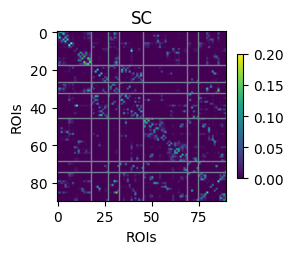

In [3]:
plt.figure(figsize=(3,3,))
plt.imshow(SC[order_mat].T)
plt.colorbar(shrink=0.5)
plt.title('SC')
plt.xlabel('ROIs')
plt.ylabel('ROIs')

# --- compute boundaries between networks ---
boundaries = np.where(np.diff(RSN_ordered) != 0)[0] + 1
# --- draw separator lines ---
for b in boundaries:
    plt.axhline(b - 0.5, color='slategray', lw=1)
    plt.axvline(b - 0.5, color='slategray', lw=1)
    
plt.tight_layout()
plt.show()

# Import fMRI data

In [4]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")
mat_data = sio.loadmat(file_path)

ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

In [5]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

# Personalized ANN

In [6]:
# -----------------------
# Train ANN for each participant
# -----------------------
# Assuming `groups` is like:
# groups = {"CNT": [np.ndarray(T,N), ...], "MCS": [...], "UWS": [...]}

S=3

models_by_group = train_models_for_groups(
    groups,
    steps=S,
    num_epochs=100,
    lr=1e-3,
    l2=5e-5,
    save_dir=None  # or None to skip saving
)

# Quick summary print
for g, lst in models_by_group.items():
    print(f"{g}: {len(lst)} trained models")
    if lst:
        h = lst[0]["history"]
        print(f"  example final losses — train {h['train_loss'][-1]:.6f}, test {h['test_loss'][-1]:.6f}")


=== Group: CNT — 13 subjects ===
[OK]  CNT[0] — T=192, N=90, W=189 | final train=0.053334, test=0.501966 (2.6s)
[OK]  CNT[1] — T=192, N=90, W=189 | final train=0.046901, test=0.469498 (1.0s)
[OK]  CNT[2] — T=192, N=90, W=189 | final train=0.043153, test=0.496903 (1.1s)
[OK]  CNT[3] — T=192, N=90, W=189 | final train=0.027984, test=0.592447 (1.1s)
[OK]  CNT[4] — T=192, N=90, W=189 | final train=0.045331, test=0.579287 (1.4s)
[OK]  CNT[5] — T=192, N=90, W=189 | final train=0.054627, test=0.466225 (1.1s)
[OK]  CNT[6] — T=192, N=90, W=189 | final train=0.037571, test=0.595864 (1.1s)
[OK]  CNT[7] — T=192, N=90, W=189 | final train=0.044080, test=0.715535 (1.2s)
[OK]  CNT[8] — T=192, N=90, W=189 | final train=0.071839, test=0.494665 (1.1s)
[OK]  CNT[9] — T=192, N=90, W=189 | final train=0.047392, test=0.571758 (1.1s)
[OK]  CNT[10] — T=192, N=90, W=189 | final train=0.045190, test=0.392709 (1.0s)
[OK]  CNT[11] — T=192, N=90, W=189 | final train=0.047475, test=0.479199 (1.2s)
[OK]  CNT[12] — 

# Effective Connectivity (and dynamic EC)

In [7]:
# ========================================================================
# For each group (g) and subject (isu):
# This block computes:
#   - ECs_sim[g][isu]  → the *average effective connectivity (EC)* matrix
#     obtained by perturbing each target region and comparing perturbed vs
#     unperturbed dynamics across all initial conditions.
#
#   - ECts_sim[g][isu] → the *time-resolved EC(t)* estimates, i.e., EC
#     computed for each time window or initial condition separately.
#
#   - dECs_sim[g][isu] → the *dynamic EC*, defined as the correlation
#     between EC(t) matrices across time — quantifying how EC patterns
#     evolve or fluctuate dynamically.
#
# The underlying rationale:
# For each model (subject), the ANN simulates brain dynamics given an
# empirical time series Z (T × N, time × regions). By perturbing each
# region (target) at each initial condition and comparing to the
# unperturbed trajectory, we estimate the directed influence each node
# exerts on others (effective connectivity).
# ========================================================================

ECs_sim = {}
ECts_sim = {}
dECs_sim = {}
pert_strength = 0.1  # strength of simulated perturbation

for g in groups_id:
    print(g)
    ECs_sim[g] = {}
    ECts_sim[g] = {}
    dECs_sim[g] = {}

    for isu in range(len(groups[g])):
        # ---------------------------------------------------------------
        # 1. Pull the subject's simulated or empirical time series
        #    Z has shape (T, N): T time points, N brain regions
        # ---------------------------------------------------------------
        Z = groups[g][isu][:T, :]

        # ---------------------------------------------------------------
        # 2. Prepare data windows for the EC model
        #    multi2one creates input-output pairs:
        #      X: (W, S*N) → concatenated S past states (inputs)
        #      Y: (W, N)   → next state to predict (targets)
        # ---------------------------------------------------------------
        X, Y = multi2one(Z, steps=S)

        # ---------------------------------------------------------------
        # 3. Compute Effective Connectivity (EC)
        #    model_EC perturbs each target region in the ANN model and
        #    compares perturbed vs unperturbed outputs. The result is an
        #    (N×N) matrix summarizing average directed effects.
        # ---------------------------------------------------------------
        ECs_sim[g][isu] = model_EC(
            models_by_group[g][isu]['model'],
            input_X=X, target_Y=Y,
            pert_strength=pert_strength
        )  # → (N, N)

        # ---------------------------------------------------------------
        # 4. Compute time-resolved EC(t)
        #    model_ECt returns EC estimates for each window or initial
        #    condition (M time points × N × N)
        # ---------------------------------------------------------------
        ECt_est = model_ECt(
            models_by_group[g][isu]['model'],
            input_X=X, target_Y=Y,
            pert_strength=pert_strength
        )  # → (M, N, N)

        # ---------------------------------------------------------------
        # 5. Reshape and extract upper-triangular edges
        #    We vectorize each EC(t) into its unique edges (E = N*(N-1)/2)
        # ---------------------------------------------------------------
        M, N, _ = ECt_est.shape
        triu_idx = np.triu_indices(N, k=1)
        ECt_est_edges = ECt_est[:, triu_idx[0], triu_idx[1]]  # → (M, E)

        # Save time-resolved EC edge series
        ECts_sim[g][isu] = ECt_est_edges

        # ---------------------------------------------------------------
        # 6. Compute dynamic EC (dEC)
        #    Correlation of EC(t) vectors across time → measures temporal
        #    co-fluctuations between connection strengths.
        # ---------------------------------------------------------------
        dECs_sim[g][isu] = np.corrcoef(ECt_est_edges)


CNT
MCS
UWS


# Bifocal Effective Connectivity - L2 dist

In [14]:
# ======================================================================
# For each group (g) and subject (isu):
# Compute the **Bifocal Effective Connectivity (BEC)**.
#
# Conceptually:
#   - BEC measures how pairs of simultaneously stimulated regions
#     (i,j) jointly affect the global brain state.
#   - Each matrix element BEC[i, j] represents the *distance in state
#     space* between the perturbed and unperturbed trajectories,
#     when regions i and j are jointly stimulated.
#   - The distance metric (e.g., 'l2', 'cosine_dist', or 'angle')
#     quantifies how different the overall system response is.
#
# Outputs:
#   BECs_sim[g][isu]  → (E,) average BEC across all time windows (mean across M)
#   BECts_sim[g][isu] → (M, E) time-resolved BEC(t)
#   dBECs_sim[g][isu] → (M, M) dynamic BEC similarity (correlation between BEC(t) patterns)
#
# Steps:
#   1. Obtain empirical/simulated state sequences (Z)
#   2. Prepare model input/output pairs (X, Y)
#   3. Compute BEC(t) across time windows using model_BECt()
#   4. Extract unique edges (upper-triangular pairs of regions)
#   5. Compute dynamic similarity (dBEC)
#   6. Average across time to obtain mean BEC per connection
# ======================================================================

BECs_sim = {}
BECts_sim = {}
dBECs_sim = {}
pert_strength = 0.1/np.sqrt(2)

for g in groups_id:
    print(g)
    BECs_sim[g] = {}
    BECts_sim[g] = {}
    dBECs_sim[g] = {}

    for isu in range(len(groups[g])):
        # ---------------------------------------------------------------
        # 1. Pull the subject’s empirical or simulated time series
        #    Z has shape (T, N): T time points × N brain regions
        # ---------------------------------------------------------------
        Z = groups[g][isu][:T, :]

        # ---------------------------------------------------------------
        # 2. Create input-output windows for the ANN model
        #    X: concatenated S past states, shape (W, S*N)
        #    Y: next state targets, shape (W, N)
        # ---------------------------------------------------------------
        X, Y = multi2one(Z, steps=S)

        # ---------------------------------------------------------------
        # 3. Compute Bifocal Effective Connectivity over time
        #    model_BECt perturbs pairs of regions (i,j) and quantifies
        #    the change in predicted system state relative to the
        #    unperturbed output, using the chosen metric (possibilities ['l2','cosine_dist', 'angle']).
        #    Returns BEC(t): (M, N, N)
        # ---------------------------------------------------------------
        BECt_est = model_BECt(
            models_by_group[g][isu]['model'],
            input_X=X,
            target_Y=Y,
            pert_strength=pert_strength,
            metric='l2'
        )  # → (M, N, N)

        # ---------------------------------------------------------------
        # 4. Extract upper-triangular edges (unique region pairs)
        #    Each time window t → vector of E = N*(N-1)/2 bifocal effects
        # ---------------------------------------------------------------
        M, N, _ = BECt_est.shape
        triu_idx = np.triu_indices(N, k=1)
        BECt_est_edges = BECt_est[:, triu_idx[0], triu_idx[1]]  # → (M, E)

        # Store time-resolved BEC
        BECts_sim[g][isu] = BECt_est_edges

        # ---------------------------------------------------------------
        # 5. Dynamic BEC (dBEC)
        #    Correlation between BEC(t) vectors across time → measures
        #    how bifocal effects co-fluctuate dynamically.
        # ---------------------------------------------------------------
        dBECs_sim[g][isu] = np.corrcoef(BECt_est_edges)

        # ---------------------------------------------------------------
        # 6. Average BEC across time
        #    Mean effect strength across all windows → static BEC summary
        # ---------------------------------------------------------------
        BECs_sim[g][isu] = tri_to_mat(np.mean(BECts_sim[g][isu], axis=0))

CNT
MCS
UWS


# Analysis and plots

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_group_connectivity(connectivity_dict, groups_id, vmax=0.01, vmin=-0.01, cmap='RdBu_r',
                            xlabel='Target region', ylabel='Source region',
                            title='Group-average Effective Connectivity'):
    """
    Plot group-average EC or BEC matrices side-by-side.

    Parameters
    ----------
    connectivity_dict : dict[group][subject] = (N, N)
        Nested dictionary with EC or BEC matrices for each subject.
    groups_id : list
        List of group names (keys of connectivity_dict).
    cmap : str
        Matplotlib colormap name (e.g. 'RdBu_r', 'plasma').
    xlabel, ylabel, title : str
        Axis labels and figure title.
    """
    n_groups = len(groups_id)

    # --- compute group-average matrices ---
    mean_mats = []
    #vmax = 0
    for g in groups_id:
        mats = np.array(list(connectivity_dict[g].values()))  # (n_subj, N, N)
        mean_mat = np.mean(mats, axis=0)
        mean_mats.append(mean_mat)
        #vmax = max(vmax, np.abs(mean_mat).max())

    # --- plot ---
    fig, axes = plt.subplots(1, n_groups, figsize=(4*n_groups, 3), constrained_layout=True)

    for i, g in enumerate(groups_id):
        ax = axes[i] if n_groups > 1 else axes
        im = ax.imshow(mean_mats[i], cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')

        ax.set_title(g, fontsize=12)
        ax.set_xlabel(xlabel)
        if i == 0:
            ax.set_ylabel(ylabel)

        # clean gridlines
        ax.spines[:].set_visible(False)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

        # colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('Connectivity strength', rotation=-90, va='bottom')

    fig.suptitle(title, fontsize=14)
    plt.show()

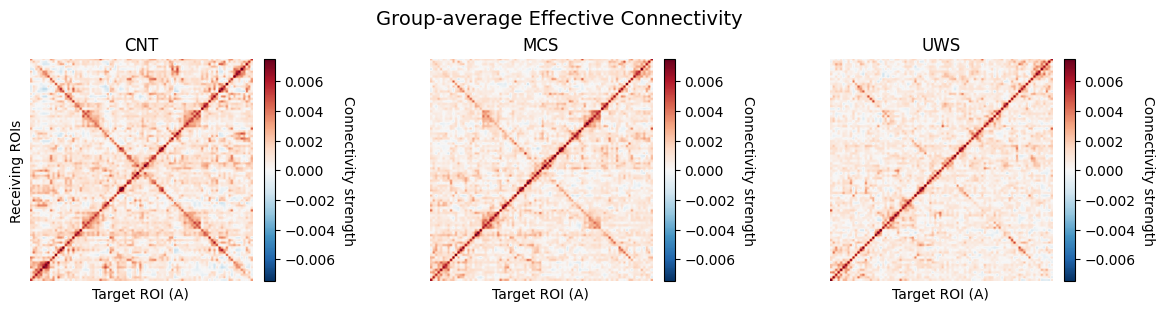

In [51]:
plot_group_connectivity(ECs_sim, groups_id, vmax=0.0075, vmin=-0.0075,
                        cmap='RdBu_r',
                        xlabel='Target ROI (A)',
                        ylabel='Receiving ROIs',
                        title='Group-average Effective Connectivity')

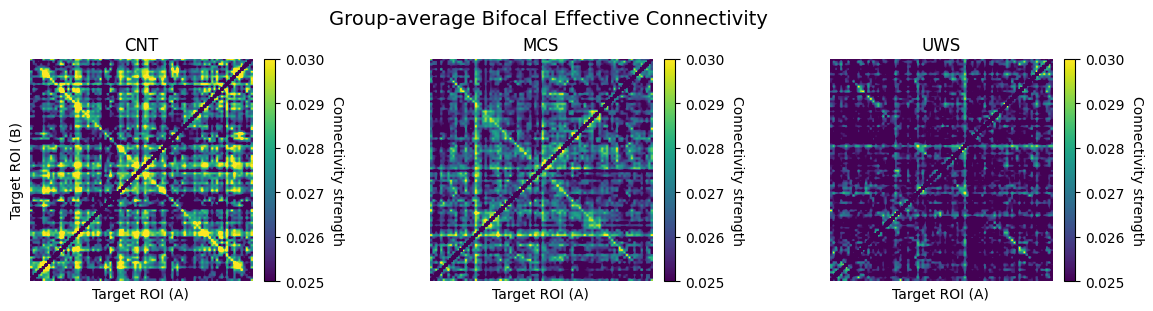

In [53]:
plot_group_connectivity(BECs_sim, groups_id, vmax=0.03, vmin=0.025,
                        cmap='viridis',
                        xlabel='Target ROI (A)',
                        ylabel='Target ROI (B)',
                        title='Group-average Bifocal Effective Connectivity')

# Group Differences

### Effective connectivity

In [54]:
# ======================================================================
# For each group (g) and subject (isu):
# Compute a scalar summary of the Effective Connectivity (EC) matrix.
#
# Each ECs_sim[g][isu] is an (N × N) matrix of directed connectivity
# values obtained from perturbation-based analysis.
#
# Here, we extract only the upper-triangular part (i<j) to avoid
# duplicating symmetric connections and then compute the mean EC value
# across all directed edges.
#
# Result:
#   Mean_EC_sim[g][isu] → average EC strength for that subject.
# This can be used to compare overall coupling magnitude across groups.
# ======================================================================

Mean_EC_sim = {}
for g in groups_id:
    Mean_EC_sim[g] = {}
    for isu in range(len(groups[g])):
        # Extract the subject’s EC matrix
        ec_mat = ECs_sim[g][isu]

        # Keep only unique directed edges (upper triangular part)
        ec = ec_mat[np.triu_indices(N, k=1)]

        # Compute mean EC strength across all edges
        Mean_EC_sim[g][isu] = np.mean(ec)

        # --- Alternative ideas (commented out below) ---
        # Option 1: count negative connections
        # Mean_EC_sim[g][isu] = np.sum(np.where(ec < 0, 1, 0))
        #
        # Option 2: normalize by total number of negative edges
        # Mean_EC_sim[g][isu] = np.sum(np.where(ec < 0, 1, 0)) / len(ec)

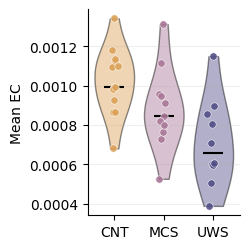

In [55]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

data = {g: np.asarray(list(Mean_EC_sim[g].values())) for g in groups_id}

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Mean EC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

In [56]:
# ======================================================================
# For each group (g) and subject (isu):
# Compute a scalar index of "fluidity" of effective connectivity (EC)
# dynamics, based on the temporal variability of EC(t).
#
# Recall:
#   dECs_sim[g][isu] → (T-S, T-S) matrix of correlations between EC(t)
#                       patterns at different times.
#                       Each entry (i,j) indicates how similar the EC
#                       structure is between time windows i and j.
#
# Here, we take the upper triangular part of dECs_sim[g][isu] (to avoid
# duplicate correlations and self-comparisons) and compute its variance.
#
# Interpretation:
#   - High variance  → EC(t) patterns fluctuate strongly over time,
#                      indicating *high fluidity* of effective connectivity.
#   - Low variance   → EC(t) remains relatively stable, i.e., more rigid
#                      or stationary dynamics.
#
# Result:
#   Fluidity_dEC_sim[g][isu] → scalar summary of how variable the dynamic
#                              EC correlations are across time for each subject.
# ======================================================================

Fluidity_dEC_sim = {}
for g in groups_id:
    Fluidity_dEC_sim[g] = {}
    for isu in range(len(groups[g])):
        # Compute variance of the upper-triangular (unique) elements of
        # the time×time correlation matrix of EC(t)
        Fluidity_dEC_sim[g][isu] = np.var(
            dECs_sim[g][isu][np.triu_indices(T - S, k=1)]
        )

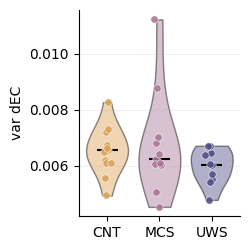

In [57]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

data = {g: np.asarray(list(Fluidity_dEC_sim[g].values())) for g in groups_id}

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("var dEC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

### Bifocal Effective connectivity

In [68]:
Mean_BEC_sim={}
for g in groups_id:
    Mean_BEC_sim[g]={}
    for isu in range(len(groups[g])):
        ec_mat=BECs_sim[g][isu]
        ec = ec_mat[np.triu_indices(N, k=1)]
        Mean_BEC_sim[g][isu]=np.mean(ec)

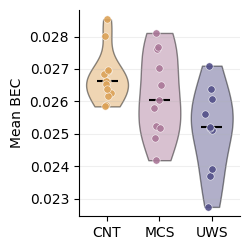

In [69]:
data = {g: np.asarray(list(Mean_BEC_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Mean BEC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

In [70]:
Fluidity_dBEC_sim={}
for g in groups_id:
    Fluidity_dBEC_sim[g]={}
    for isu in range(len(groups[g])):
        Fluidity_dBEC_sim[g][isu]=np.var(dECs_sim[g][isu][np.triu_indices(T-S, k=1)])

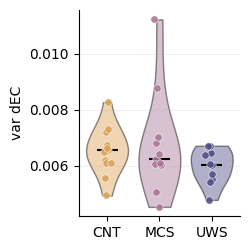

In [71]:
data = {g: np.asarray(list(Fluidity_dEC_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("var dEC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

# Groups Classification